# Sample-Reference distance vs. sample-sample distnace

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from seaborn import despine
from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import metric_utils
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

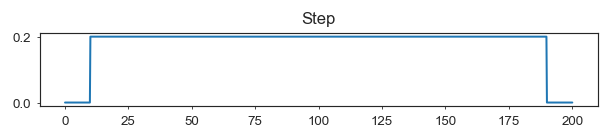

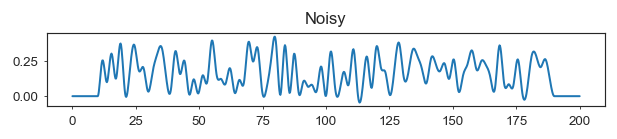

In [6]:
from neuroprobnum.utils import stim_utils
t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stims = [
    stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step'),
    stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46),

]
for stim in stims: stim.plot(t0=t0, tmax=tmax)

# Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
from copy import deepcopy

gens = {}

for stim in stims:
    
    neuron = deepcopy(neuron)
    neuron.get_Istim_at_t = stim.get_I_at_t
    
    gens[stim] = DataGeneratorHH(
        t0=t0, tmax=tmax, t_eval_adaptive=math_utils.t_arange(t0, tmax, 5),
        return_vars=['events', 'ys'],
        model=neuron, y0=neuron.compute_yinf(-65), thresh=0.0,
        n_samples=100, n_parallel=20,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data'
    )
    gens[stim].update_subfoldername(stim=stim.name)
    gens[stim].load_acc_sols_from_file()    

Not acc sols file found!
Not acc sols file found!


## Data

In [8]:
# pert_method, adaptive, methods, step_params
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.5, 0.25, 0.1, 0.025, 0.01, 0.005], [0.1, 1.0, 10.]),
    ('abdulle_ln', 0, ['EEMP'], [0.5, 0.25, 0.1, 0.025, 0.01], [0.1, 1.0, 10.]),
    ('abdulle_ln', 0, ['FE'], [0.05, 0.025, 0.01, 0.005], [0.1, 1.0, 10.]),
    ('conrad', 1, ['RKBS'], [1e-2, 1e-4, 1e-6], [0.1, 1.0, 10.]),
]

In [9]:
for stim, gen in gens.items():
    
    print('----------------------------------------------------------')
    print(stim, ':', gen.subfoldername)
    print('----------------------------------------------------------')
    
    for pert_method, adaptive, methods, step_params, pert_params in solver_params:
        for step_param, method, pert_param in itproduct(step_params, methods, pert_params):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, pert_param=pert_param,
                overwrite=False, allowgenerror=True,
            )

----------------------------------------------------------
IStimStep(0.2,t=[10,190]) : stim_Step_tmax_200
----------------------------------------------------------
                               EE_f(0.5)_abdulle_ln(0.1).pkl --> Generate data because file was not found.
No suited acc_ts found in 0 acc_ts. Create reference solution!
2 times the following warning: inefficient
                                 EE_f(0.5)_abdulle_ln(1).pkl --> Generate data because file was not found.
                                EE_f(0.5)_abdulle_ln(10).pkl --> Generate data because file was not found.
                              EE_f(0.25)_abdulle_ln(0.1).pkl --> Generate data because file was not found.
No suited acc_ts found in 1 acc_ts. Create reference solution!
2 times the following warning: inefficient
                                EE_f(0.25)_abdulle_ln(1).pkl --> Generate data because file was not found.
                               EE_f(0.25)_abdulle_ln(10).pkl --> Generate data because f

# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = pd.DataFrame()
for stim, gen in gens.items():
    stim_df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, allowgenerror=True)   
    stim_df['stimfun'] = stim
    stim_df['stim'] = stim.name
    df = df.append(stim_df, ignore_index=True)

In [11]:
df.head()

,MAE_DR,MAE_SM,MAE_SR,acc_events,acc_ts,acc_vs,adaptive,det_events,det_nODEcalls,det_run_time,...,pert_param,run_times,seed,step_param,t0,tmax,ts,vs,stimfun,stim
0,22.167441,"[1.998538945129135, 3.899680273059327, 8.37252...","[22.168589152992425, 21.91318352075587, 21.971...","[[11.270881645965623, 23.333899356067096, 34.9...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.4999999999999893, ...","[-65.0, -64.99985700733349, -64.99973901799655...",0,"[[12.390282132162337, 27.96742811183181, 42.87...",400.0,0.012033,...,0.1,"[0.03111100196838379, 0.030280590057373047, 0....","[12475674, 1080776788, 1858585705, 1629164900,...",0.50,0.0,200.0,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[[-65.0, -64.99986470707525, -64.9997628090810...","IStimStep(0.2,t=[10,190])",Step
1,22.167441,"[13.279057719504763, 15.17329223314543, 16.254...","[23.386799385974566, 24.182361430092794, 22.74...","[[11.270881645965623, 23.333899356067096, 34.9...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.4999999999999893, ...","[-65.0, -64.99985700733349, -64.99973901799655...",0,"[[12.390282132162337, 27.96742811183181, 42.87...",400.0,0.013538,...,1.0,"[0.04041743278503418, 0.016857385635375977, 0....","[12475674, 1080776788, 1858585705, 1629164900,...",0.50,0.0,200.0,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[[-65.0, -64.99989744024458, -64.9997710818450...","IStimStep(0.2,t=[10,190])",Step
2,22.167441,"[15.164204189834626, 16.601933569795122, 15.03...","[21.890204891390233, 25.745289522388003, 23.40...","[[11.270881645965623, 23.333899356067096, 34.9...","[0.0, 0.5, 1.0, 1.5, 2.0, 2.4999999999999893, ...","[-65.0, -64.99985700733349, -64.99973901799655...",0,"[[12.390282132162337, 27.96742811183181, 42.87...",400.0,0.014167,...,10.0,"[0.02494192123413086, 0.018666982650756836, 0....","[12475674, 1080776788, 1858585705, 1629164900,...",0.50,0.0,200.0,"[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, ...","[[-65.0, -64.9999853521807, -64.99991599590956...","IStimStep(0.2,t=[10,190])",Step
3,21.714283,"[1.3014203933107138, 6.06434870847111, 3.07697...","[21.497688321320037, 21.984006563733836, 21.78...","[[11.270881645965627, 23.333899356067285, 34.9...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992457182115, -64.9998570073335,...",0,"[[11.850855243541666, 25.65387713167099, 38.90...",800.0,0.023995,...,0.1,"[0.06187582015991211, 0.03326725959777832, 0.0...","[12475674, 1080776788, 1858585705, 1629164900,...",0.25,0.0,200.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[[-65.0, -64.99992635902919, -64.9998616419031...","IStimStep(0.2,t=[10,190])",Step
4,21.714283,"[9.725600435805239, 17.9466096200056, 14.07567...","[20.79742535930405, 21.47295425326134, 21.0784...","[[11.270881645965627, 23.333899356067285, 34.9...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992457182115, -64.9998570073335,...",0,"[[11.850855243541666, 25.65387713167099, 38.90...",800.0,0.026551,...,1.0,"[0.06297659873962402, 0.050069570541381836, 0....","[12475674, 1080776788, 1858585705, 1629164900,...",0.25,0.0,200.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[[-65.0, -64.99993881026417, -64.9998622452679...","IStimStep(0.2,t=[10,190])",Step


### Add spike distance

In [12]:
df['spikedist_SR'] = None
df['spikedist_SM'] = None

for i, row in df.iterrows():
    
    if row.n_samples == 0:
        continue
    
    samples = [np.array(e_list[0]) for e_list in row.events]
    target = row.acc_events[0]
    
    spikedist_SR = metric_utils.compute_sample_target_distances(samples=samples, target=target, metric='spikes', t0=row.t0, tmax=row.tmax)
    spikedist_SM = metric_utils.compute_sample_sample_distances(samples=samples, metric='spikes', t0=row.t0, tmax=row.tmax)
    
    df.at[i, 'spikedist_SR'] = spikedist_SR
    df.at[i, 'spikedist_SM'] = spikedist_SM

# Plot

In [13]:
def plot_metric_panel(ax, df, x, y, legend=True, legend_kw=None):
    plot_methods = []
    for (method, adaptive, pert_method), subgroup in df.groupby(['method', 'adaptive', 'pert_method'], sort=False):
    
        x_data = []
        y_data = []
        for _, data_row in subgroup.iterrows():
            if data_row['n_samples'] > 0:
                x_data.append(np.atleast_1d(data_row[x]))
                y_data.append(data_row[y])
    
        if len(x_data) > 0 and ((method, adaptive, pert_method) not in plot_methods):
            plot_methods.append((method, adaptive, pert_method))
    
        pltu.plot_xy_percentiles(
            ax, datax=x_data, datay=y_data,
            marker=pltu.method2marker(method), color=pltu.method2color(method),
            mean_kw=dict(alpha=0.5, ls=pltu.mode2ls(adaptive), mfc=pltu.mode2mfc(adaptive), ms=6, clip_on=False),
            line_kw=dict(lw=1, alpha=0.75),
        )
        pltu.grid(ax)
        
    if legend:
        legend_kw_plot = dict(loc='lower left', bbox_to_anchor=(0.03, 0), handlelength=0.9)
        
        if legend_kw is not None:
            legend_kw_plot.update(legend_kw)
            
        pltu.make_method_mode_single_legend(
            ax=ax, methods=[m[0] for m in plot_methods], modes=[m[1] for m in plot_methods], pert_methods=[m[2] for m in plot_methods],
            legend_kw=legend_kw_plot)

In [14]:
def plot_metric(axs, df, metric, metriclabel=None, legend=True):
    assert len(axs) == 3
    
    if metriclabel is None:
        metriclabel = metric
    
    ax = axs[0]
    plot_metric_panel(ax=ax, df=df, x='det_nODEcalls', y=f'{metric}_SR', legend=legend)
    ax.set(xscale='log', yscale='log', ylabel=f'Smp.-Ref. {metriclabel}', xlabel='# ODE evaluations')

    ax = axs[1]
    plot_metric_panel(ax=ax, df=df, x='det_nODEcalls', y=f'{metric}_SM', legend=False)
    ax.set(xscale='log', yscale='log', ylabel=f'Smp.-Smp. {metriclabel}', xlabel='# ODE evaluations')

    ax = axs[2]
    plot_metric_panel(ax=ax, df=df, x=f'{metric}_SR', y=f'{metric}_SM', legend=False)
    ax.set(xscale='log', yscale='log', ylabel=f'Smp.-Smp. {metriclabel}', xlabel=f'Smp.-Ref. {metriclabel}',)
    ax.set_aspect('equal', adjustable='datalim')

In [15]:
stim = stims[1]
stim

IStimNoisy(0.2,t=[10,190],I=[0.00,0.00])

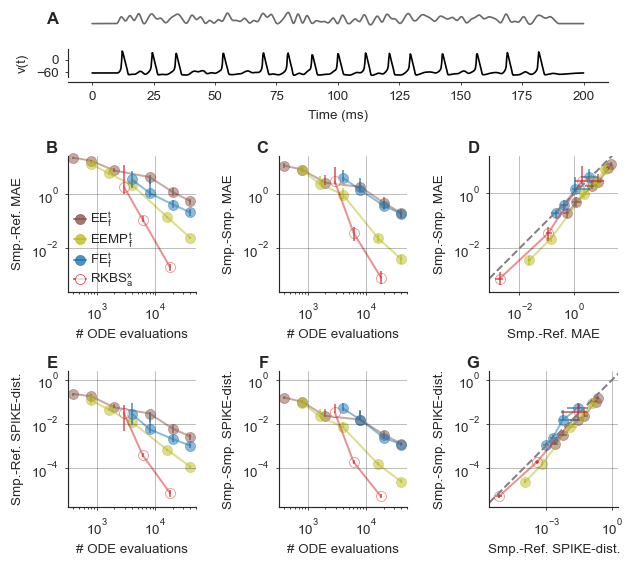

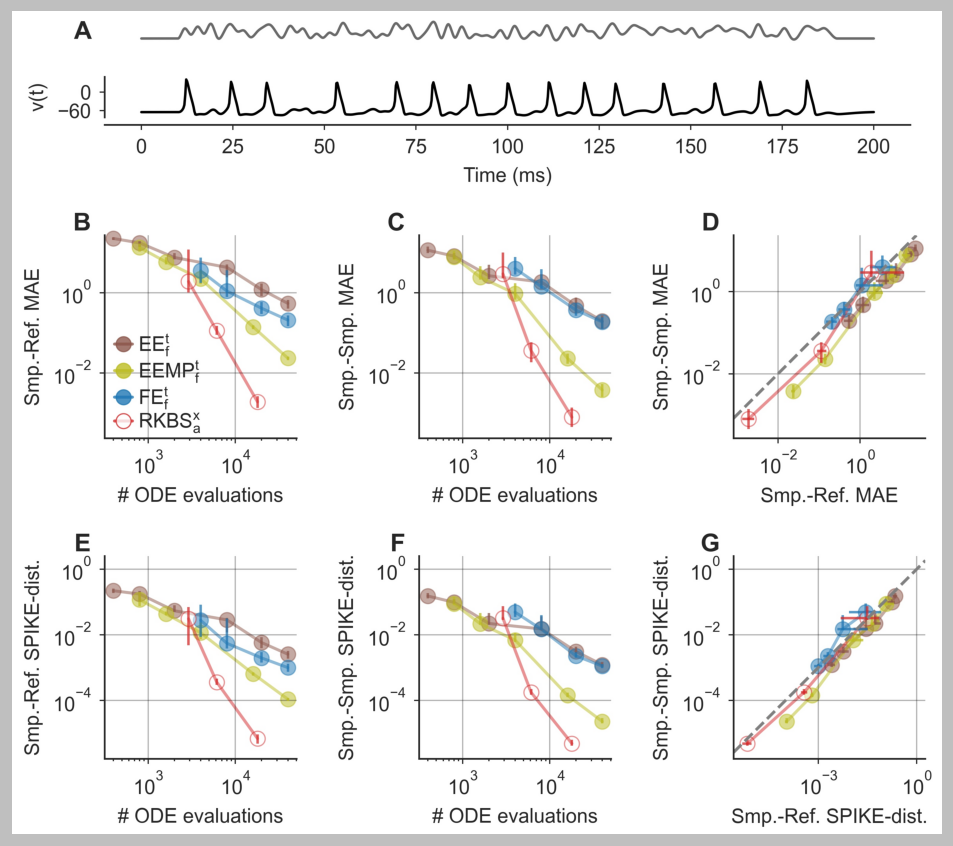

In [16]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs

### Prepare axes ###
num_cols = 3
num_rows = 4

fig, axs = pltu.subplots(
    num_cols, num_rows, xsize='text',
    ysizerow=1.05, yoffsize=0.4, squeeze=False,
    gridspec_kw=dict(height_ratios=[0.1, 0.2, 1.0, 1.0]),
)

for ax in axs[:2, 1:].flat:
    ax.remove()
    
despine()

### Plot stimulus ###
row = df[(df.method=='EE') & (df.adaptive==0) & (df.step_param==0.25) & (df.stim==stim.name) & (df.pert_param==1.0)]
assert len(row) == 1
row = row.iloc[0]
assert row.n_samples > 0, 'Pick an example that terminated'
    
stim_ts = np.arange(t0, tmax, 0.01)
plot_stim(ax=axs[0, 0], ts=stim_ts, stim=[row.stimfun.get_I_at_t(t=t) for t in stim_ts])
plot_vs(ax=axs[1, 0], ts=row.acc_ts, vs=row.acc_vs, c='k')
       
plot_metric(axs[2, :], df=df[(df.stim==stim.name) & (df.pert_param==1.0)], metric='MAE')

plot_metric(axs[3, :], df=df[(df.stim==stim.name) & (df.pert_param==1.0)], metric='spikedist', metriclabel='SPIKE-dist.', legend=False)

# Decorate
axs[0, 0].axis('off')
pltu.move_xaxis_outward(axs[1, :])

for ax in axs[2:, 2].flat:
    ax.axline([0.1, 0.1], [1, 1], c='gray', ls='--')

plt.tight_layout(h_pad=0.2, pad=0.5, w_pad=2, rect=[0, 0.04, 1, 1])

pltu.set_labs(axs[0,0], panel_nums='A', panel_num_va='top', panel_num_y=1, panel_num_space=2)
pltu.set_labs(axs[2,:], panel_nums=['B', 'C', 'D'], panel_num_va='bottom', panel_num_y=1, panel_num_space=2)
pltu.set_labs(axs[3,:], panel_nums=['E', 'F', 'G'], panel_num_va='bottom', panel_num_y=1, panel_num_space=2)

pltu.move_box(axs[1, :], dy=0.05)
pltu.change_box(axs=axs[:2, 0], dx=0.66, dy=0)
pltu.move_box(axs[-1, :], dy=-0.05)

# Arange (very hard-coded,but otherwise it does no work because limits are adjustest despite setting auto to False)
pltu.make_share_xlims(axs[2:, :2])
pltu.make_share_ylims(axs[2, :2], ylim=(0.0002398499114228449, 26.658228059411517))    
pltu.make_share_ylims(axs[3, :2], ylim=axs[3, 2].set_ylim(auto=False))

pltu.savefig("fig5")
plt.show()
pltu.show_saved_figure(fig)

## Text

In [17]:
for method, group in df.groupby('method'):
    print(method, group[group.n_samples > 0].step_param.max())

EE 0.5
EEMP 0.5
FE 0.05
RKBS 0.01
